In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import Counter
from itertools import groupby

##Import Musics and Tags

In [3]:
# Import user_taggedartists Data set
music_df = pd.read_csv("/content/drive/My Drive/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat", sep = "\s+")
print("Number of Unique userID: ", len(music_df.userID.unique()))
print("Number of Unique artistID: ", len(music_df.artistID.unique()))
print("Number of Unique TagID: ", len(music_df.tagID.unique()))
music_df.head()

Number of Unique userID:  1892
Number of Unique artistID:  12523
Number of Unique TagID:  9749


,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


In [20]:
# Count tags per artist
artistID = collections.defaultdict(list)
for index, row in music_df.iterrows():
  artistID[row['artistID']].append(row['tagID'])
mutipletags = []
for i in artistID.values():
  if len(i) > 1:
    mutipletags.append(i)
print("There are", len(mutipletags), "artist with mutiple tags")

There are 10790 artist with mutiple tags


In [5]:
# Import tags Data set
tag_df = pd.read_csv("/content/drive/My Drive/hetrec2011-lastfm-2k/tags.dat", encoding='latin-1', sep = "\t")
print("Number of Unique TagID: ", len(tag_df.tagID.unique()))
tag_df.head()

Number of Unique TagID:  11946


,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


##Musics and Tags dataset

In [22]:
music_tags = music_df.merge(tag_df, on = 'tagID', how='left')
print(len(music_tags))
music_tags.head()

186479


,userID,artistID,tagID,timestamp,tagValue
0,2,52,13,1238536800000,chillout
1,2,52,15,1238536800000,downtempo
2,2,52,18,1238536800000,electronic
3,2,52,21,1238536800000,trip-hop
4,2,52,41,1238536800000,female vovalists


In [23]:
tags_count = music_tags['tagValue'].value_counts()
tags_count[:10]

rock                7503
pop                 5418
alternative         5251
electronic          4672
indie               4458
female vocalists    4228
80s                 2791
dance               2739
alternative rock    2631
classic rock        2287
Name: tagValue, dtype: int64

In [24]:
# Create New tag
all_tags = pd.DataFrame(tags_count).reset_index()
all_tags = all_tags.sort_values(by=['tagValue'], ascending=False).reset_index(drop=True).rename(columns={"index": "tagValue","tagValue" : "frequency"})
all_tags['ranking'] = all_tags['frequency'].rank(ascending=False) # Create ranking column
#cutoff = np.percentile(all_tags['frequency'], 80) 
cutoff = 1000
all_tags.loc[all_tags['frequency'] < cutoff, 'tagValue_new'] = 'other' 
all_tags.tagValue_new = all_tags.tagValue_new.fillna(value=all_tags.tagValue) # Create new tagvalue
rank_dict = all_tags.set_index('ranking')['tagValue_new'].to_dict()
all_tags

,tagValue,frequency,ranking,tagValue_new
0,rock,7503,1.0,rock
1,pop,5418,2.0,pop
2,alternative,5251,3.0,alternative
3,electronic,4672,4.0,electronic
4,indie,4458,5.0,indie
...,...,...,...,...
9744,country favorites,1,7063.0,other
9745,adult alternative rock,1,7063.0,other
9746,taylor,1,7063.0,other
9747,romolo di prisco,1,7063.0,other


Text(0.5, 0, 'Frequency')

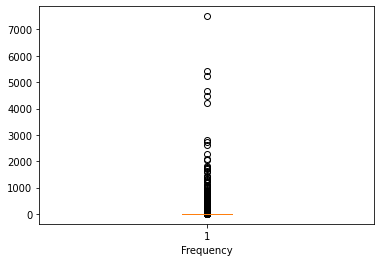

In [25]:
plt.boxplot(all_tags['frequency'])
plt.xlabel("Frequency")

In [ ]:
all_tags.to_csv('all_tags.csv', index = False)

In [ ]:
music_dup = music_tags.sort_values(by=['userID', 'artistID']).reset_index(drop=True)
music_dup1 = music_dup[music_dup.duplicated(['userID', 'artistID'])]
print('Number of duplicate entries with same userId and artistID: ', len(music_dup1))

Number of duplicate entries with same userId and artistID:  115415


Minimum number of tags per user 1
Maximum number of tags per user 2609


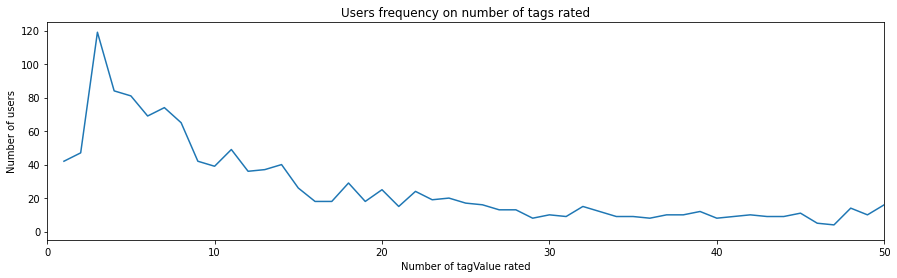

In [ ]:
df = music_tags.pivot_table(index = 'userID',  values = 'tagValue', aggfunc=np.count_nonzero).reset_index().rename(columns = {'tagValue':'no_of_tagValue'})
df1 = df.pivot_table(index = 'no_of_tagValue',  values = 'userID', aggfunc=np.count_nonzero).reset_index().rename(columns = {'userID':'no_of_users'})
print("Minimum number of tags per user", min(df['no_of_tagValue']))
print("Maximum number of tags per user", max(df['no_of_tagValue']))

fig, ax = plt.subplots(figsize=(15,4))
plt.title("Users frequency on number of tags rated")
plt.plot(df1['no_of_tagValue'], df1['no_of_users'])
plt.xlabel('Number of tagValue rated')
plt.ylabel('Number of users')
ax.set(xlim = [0,50])
plt.show()

##Create Popular Dataset

In [ ]:
# Define Top N popular
N = 100
popular_tags = all_tags.head(N)
popular_tags['popular'] = True
music_tags_popular = music_tags.merge(popular_tags, how='left').fillna(False)
popularity_count = music_tags_popular.groupby('popular')['tagID'].count()
print("Portion of popular tags", popularity_count[1]/(popularity_count[0] + popularity_count[1]))
music_tags_popular.head()

Portion of popular tags 0.6072909013883601


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,userID,artistID,tagID,timestamp,tagValue,rank,popular
0,2,52,13,1238536800000,chillout,21,True
1,2,52,15,1238536800000,downtempo,52,True
2,2,52,18,1238536800000,electronic,4,True
3,2,52,21,1238536800000,trip-hop,37,True
4,2,52,41,1238536800000,female vovalists,False,False


In [ ]:
# Select only popular tags
popular_df = music_tags_popular[music_tags_popular['popular'] == True]

# Create a new dataset that contains concat columns
music_tags_unique = popular_df[['userID', 'artistID', 'timestamp']].drop_duplicates()
list_users = list(music_tags_unique['userID'])
list_artist = list(music_tags_unique['artistID'])
list_timestamp = list(music_tags_unique['timestamp'])

# Dict for append
my_dict = collections.defaultdict(list)
for index, row in popular_df.iterrows():
  my_dict[row['userID'], row['artistID'], row['timestamp']].append(row['tagValue'])

# Create dataset
# dictionary of lists  
dict = {'userID': list_users, 'artistID': list_artist, 'timestamp': list_timestamp, 'tagValue': list(my_dict.values())}      
music_tags_new = pd.DataFrame(dict) 
music_tags_new['tagValue'] = ['|'.join(map(str, l)) for l in music_tags_new['tagValue']]
print("Dataset contains", len(music_tags_new), "rows")
music_tags_new.head()

Dataset contains 58980 rows


,userID,artistID,timestamp,tagValue
0,2,52,1238536800000,chillout|downtempo|electronic|trip-hop
1,2,63,1238536800000,chillout|ambient
2,2,73,1238536800000,chillout|ambient|downtempo|electronic|trip-hop
3,2,94,1238536800000,chillout|downtempo|trip-hop|dance
4,2,96,1238536800000,pop


##Create majority dataset

In [ ]:
# Select only artist
music_rank = music_tags.merge(all_tags, on = 'tagValue', how='left')
artists_df = music_rank[['artistID','ranking']]

# Dict for append
my_dict = collections.defaultdict(list)
for index, row in artists_df.iterrows():
  my_dict[row['artistID']].append(row['ranking'])

# Choose only majority tagvalue for each artist
for key, value in my_dict.items():
  counter = collections.Counter(sorted(value))
#  if len(counter.most_common(2)) > 1:
#    rank2 = [rank_dict[counter.most_common(2)[0][0]],rank_dict[counter.most_common(2)[1][0]]] # Two tagvalue
#    if rank2[0] == rank2[1]:
#      my_dict[key] = 'other'
#    else:
#      my_dict[key] = '|'.join([str(elem) for elem in rank2])
#  else:
  my_dict[key] = rank_dict[counter.most_common(2)[0][0]]


music_tags_unique = music_df[['userID', 'artistID', 'timestamp']].drop_duplicates()
list_users = list(music_tags_unique['userID'])
list_artist = list(music_tags_unique['artistID'])
list_timestamp = list(music_tags_unique['timestamp'])

# Dict for append
my_dict_2 = collections.defaultdict(list)
for index, row in music_tags_unique.iterrows():
  my_dict_2[row['userID'], row['artistID'], row['timestamp']] = my_dict[row['artistID']]

In [ ]:
# Create dataset
# dictionary of lists  
dict = {'userID': list_users, 'artistID': list_artist, 'timestamp': list_timestamp, 'tagValue': list(my_dict_2.values())}      
music_tags_new = pd.DataFrame(dict)
print("Dataset contains", len(music_tags_new), "rows")
print("Number of Unique userID: ", len(music_tags_new.userID.unique()))
print("Number of Unique artistID: ", len(music_tags_new.artistID.unique()))
print("Number of Unique TagValue: ", len(music_tags_new.tagValue.unique()))
music_tags_new.head()

Dataset contains 87061 rows
Number of Unique userID:  1892
Number of Unique artistID:  12523
Number of Unique TagValue:  33


,userID,artistID,timestamp,tagValue
0,2,52,1238536800000,other
1,2,63,1238536800000,ambient
2,2,73,1238536800000,chillout
3,2,94,1238536800000,dance
4,2,96,1238536800000,classic rock


##Export CSV for model training

In [ ]:
music_tags_new.to_csv('/content/drive/My Drive/hetrec2011-lastfm-2k/music_tags_new.csv', index = False)

#Model

In [ ]:
import pickle
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [ ]:
def get_top_k_items(dataframe, k):    
    """ Create data frame that return top k ratings from each user
    
    Parameters
    ----------
    dataframe : dataframe input (required columns: user_id and prediction)
    k : Number of top k 

    Returns
    -------
    top_k_df : Sorted top k dataframe by user_id with additional rank columns 
        
    """
    
    # Sort dataframe by col_user and (top k) col_rating
    top_k_df = (dataframe.groupby('user_id', as_index=False)
        .apply(lambda x: x.nlargest(k, 'prediction'))
        .reset_index(drop=True))
    
    # Add ranks
    top_k_df["rank"] = top_k_df.groupby('user_id', sort=False).cumcount() + 1
    
    return top_k_df

def merge_ranking_true_pred(test_df, pred_df, k):    
    """ Create dataFrmae of hit counts vs actual relevant items per user number of unique user ids
    
    Parameters
    ----------
    test_df : Real rating dataframe (required columns: user_id and item_id)
    pred_df : Predicted rating dataframe (required columns: user_id, Recommended_artistID and prediction)
    k : Number of top k 

    Returns
    -------
    df_hit : Dataframe contains hits items per user
    df_hit_count : Dataframe contains the number of hits vs actual relevant items per user 
    n_users : Number of common users in both rating_true and rating_pred
        
    """
        
    # Make sure the prediction and true data frames have the same set of users
    common_users = set(test_df['user_id']).intersection(set(pred_df['user_id']))
    test_df_common = test_df[test_df['user_id'].isin(common_users)]
    pred_df_common = pred_df[pred_df['user_id'].isin(common_users)]
    n_users = len(common_users)

    # Create dataframe that contains hits items per user
    df_hit = get_top_k_items(pred_df_common, k)
    df_hit = pd.merge(df_hit, test_df_common, left_on = ['user_id', 'Recommended_artistID'], 
                      right_on = ['user_id','item_id'])[['user_id', 'Recommended_artistID', "rank"]]

    # Count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby('user_id', as_index=False)['user_id'].agg({"hit": "count"}),
        test_df_common.groupby('user_id', as_index=False)['user_id'].agg({"actual": "count"}),on='user_id')

    return df_hit, df_hit_count, n_users

def rmse(test_df, pred_df):
    """ Calculates RMSE for a given dataset
    
    Parameters
    ----------
    test_df : Real rating dataframe (required columns: user_id, item_id and rating)
    pred_df : Predicted rating dataframe (required columns: user_id, Recommended_artistID)

    Returns
    -------
    the calculated RMSE
        
    """
    
    # Create joined table to get rating predicted
    rating_true_pred = pd.merge(test_df, pred_df, left_on = ['user_id', 'item_id'], 
                                right_on = ['user_id','Recommended_artistID'])
    return np.sqrt(mean_squared_error(test_df['rating'] , rating_true_pred['prediction']))

def precision_at_k(test_df, pred_df, k):
    """ Calculate precision at k
    
    Parameters
    ----------
    test_df : Real rating dataframe (required columns: user_id, item_id)
    pred_df : Predicted rating dataframe (required columns: user_id, Recommended_artistID)
    k : Number of top k 

    Returns
    -------
    the calculated precision@K
        
    """

    df_hit, df_hit_count, n_users = merge_ranking_true_pred(test_df, pred_df, k)

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / k).sum() / n_users

def recall_at_k(test_df, pred_df, k):
    """ Calculate recall at k
    
    Parameters
    ----------
    test_df : Real rating dataframe (required columns: user_id, item_id)
    pred_df : Predicted rating dataframe (required columns: user_id, Recommended_artistID)
    k : Number of top k 

    Returns
    -------
    the calculated recall@K
    
    """
        
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(test_df, pred_df, k)

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

def map_at_k(test_df, pred_df, k):    
    """ Calculate mean average precision at k
    
    Parameters
    ----------
    test_df : Real rating dataframe (required columns: user_id, item_id)
    pred_df : Predicted rating dataframe (required columns: user_id, Recommended_artistID and prediction)
    k : Number of top k 

    Returns
    -------
    the calculated MAP@K
    
    """
    
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(test_df, pred_df, k)

    # No match case
    if df_hit.shape[0] == 0:
        return 0.0

    # calculate reciprocal rank of items for each user and sum them up
    df_hit_sorted = df_hit.copy()
    df_hit_sorted["rr"] = (df_hit_sorted.groupby('user_id').cumcount() + 1) / df_hit_sorted["rank"]
    df_hit_sorted = df_hit_sorted.groupby('user_id').agg({"rr": "sum"}).reset_index()

    df_merge = pd.merge(df_hit_sorted, df_hit_count, on = 'user_id')
    
    return (df_merge["rr"] / df_merge["actual"]).sum() / n_users

def ndcg_at_k(test_df, pred_df, k):    
    """ Calculate Calculate Normalized discounted cumulative gain at k
    
    Parameters
    ----------
    test_df : Real rating dataframe (required columns: user_id, item_id)
    pred_df : Predicted rating dataframe (required columns: user_id, Recommended_artistID and prediction)
    k : Number of top k 

    Returns
    -------
    the calculated NDCG@K
    
    """

    df_hit, df_hit_count, n_users = merge_ranking_true_pred(test_df, pred_df, k)

    if df_hit.shape[0] == 0:
        return 0.0

    # calculate discounted gain for hit items
    df_dcg = df_hit.copy()
    # relevance in this case is always 1
    df_dcg["dcg"] = 1 / np.log1p(df_dcg["rank"])
    # sum up discount gained to get discount cumulative gain
    df_dcg = df_dcg.groupby('user_id', as_index=False, sort=False).agg({"dcg": "sum"})
    # calculate ideal discounted cumulative gain
    df_ndcg = pd.merge(df_dcg, df_hit_count, on=['user_id'])
    df_ndcg["idcg"] = df_ndcg["actual"].apply(
        lambda x: sum(1 / np.log1p(range(1, min(x, k) + 1))) )

    # DCG over IDCG is the normalized DCG
    return (df_ndcg["dcg"] / df_ndcg["idcg"]).sum() / n_users

In [ ]:
# Import user_taggedartists Data set
music_df = pd.read_csv("/content/drive/My Drive/hetrec2011-lastfm-2k/music_tags_new.csv")
music_df.head()

,userID,artistID,timestamp,tagValue
0,2,52,1238536800000,other
1,2,63,1238536800000,ambient
2,2,73,1238536800000,chillout
3,2,94,1238536800000,dance
4,2,96,1238536800000,classic rock


In [ ]:
# Select only user who listen at least 41 artists
df = music_df.pivot_table(index = 'userID',  values = 'artistID', aggfunc=np.count_nonzero).reset_index().rename(columns = {'artistID':'no_of_artists'})
list_id = list(df[df['no_of_artists'] <= 41]['userID'])
music_df_new = music_df[~music_df['userID'].isin(list_id)]
df_new = music_df_new.pivot_table(index = 'userID',  values = 'artistID', aggfunc=np.count_nonzero).reset_index().rename(columns = {'artistID':'no_of_artists'})
print("Minimum number of artists per user", min(df_new['no_of_artists']))
print("New datset contains", len(music_df_new), "rows")

# Sorted timestamp by userid
music_df_new['user_id'] = music_df_new['userID'].astype("category").cat.codes
music_sort = music_df_new.sort_values(by=['userID', 'timestamp']).reset_index(drop=True)
all_users = list(np.sort(music_sort.userID.unique()))
all_items = list(np.sort(music_sort.artistID.unique()))

Minimum number of artists per user 42
New datset contains 72493 rows


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
print("Number of Unique userID: ", len(music_df_new.userID.unique()))
print("Number of Unique artistID: ", len(music_df_new.artistID.unique()))
print("Number of Unique tagValue: ", len(music_df_new.tagValue.unique()))

Number of Unique userID:  419
Number of Unique artistID:  11460
Number of Unique tagValue:  33


In [ ]:
# Get last k artists per user
k = 20
last_listen = music_sort.groupby(['userID']).tail(k)

##Split train test dataset

In [ ]:
def train_test_split(df,n):
    """
    Splits our original data into one test and one training set. 
    The test set is made up of one item for each user. This is our holdout item used to compute Top@K later.
    The training set is the same as our original data but without any of the holdout items.
    Args:
        df (dataframe): Our original data
    Returns:
        df_train (dataframe): All of our data except holdout items
        df_test (dataframe): Only our holdout items.
    """

    # Create two copies of our dataframe that we can modify
    df_test = df.copy(deep=True)
    df_train = df.copy(deep=True)

    # Group by user_id and select only the last n item
    # Test dataframe
    df_test = df_test.groupby(['user_id']).tail(n)
    df_test = df_test[['userID', 'user_id', 'artistID']]

    # Remove the test set from the test set
    mask_test = df_test.index
    df_train = df_train.drop(mask_test)
    df_train = df_train[['userID', 'user_id', 'artistID']]

    return df_train, df_test

k = 20
df_train, df_test = train_test_split(music_sort,k)

In [ ]:
# 405 items with cold start problem

df_train['item_id'] = df_train['artistID'].astype("category").cat.codes
item_list = df_train[['artistID', 'item_id']]
item_list = item_list.drop_duplicates()
item_list.to_csv("/content/drive/My Drive/hetrec2011-lastfm-2k/item_list.csv", index=False)
df_test_new = pd.merge(df_test, item_list, how = 'left', left_on= 'artistID', right_on='artistID')
df_test_new.isnull().sum()

userID        0
user_id       0
artistID      0
item_id     866
dtype: int64

In [ ]:
# item_id - category coding is in both datasets
print("training set: ", df_train.shape)
print("testing set: ", df_test_new.shape)

training set:  (64113, 4)
testing set:  (8380, 4)


In [ ]:
# Create a dictionary contains watched artists for each user
training_dict = df_train.groupby('user_id')['item_id'].apply(lambda x: x.tolist())
training_dict = training_dict.to_dict()

# Function to random select unwatch artists
def artists_choice(user_id, n):
    choice = set(item_list['item_id']) - set(training_dict[user_id])
    rand_artists = np.random.choice(list(choice), n)
    return list(rand_artists)

def get_train_instances(train, training_dict, ratio):
    # Positive instances
    user_train = list(train['user_id'])
    item_train = list(train['item_id'])
    labels = [1] * len(user_train)

    # Negative instances
    for k, v in training_dict.items():
      num_negatives = len(v) * ratio # Define number of negative sampling by given ratio
      user_train.extend(([k] * num_negatives))
      item_train.extend(artists_choice(k, num_negatives))
      labels.extend(([0] * num_negatives))

    return user_train, item_train, labels

In [ ]:
def prediction(training_data, model = 'gmf_model', K = 5):
  df = training_data.iloc[:]
  df_items_unique = df['item_id'].unique()
  df_users_unique = df['user_id'].unique()
  batch_size = 128

  top_k_df = pd.DataFrame()
  for users in range(len(df_users_unique)):
    users_df  = df_users_unique[users]
    artists_watched = df[df['user_id'] == users]['item_id'].unique()
    artists_notwatched = list(set(df_items_unique) - set(artists_watched)) # to be used for prediction

    test_user_input = np.repeat(users, len(artists_notwatched)).reshape(-1,1).astype('int64')
    test_item_input = np.array(artists_notwatched).reshape(-1,1).astype('int64')

  
    if model == 'gmf_model':
      pred_test = gmf_model.predict([test_user_input, test_item_input]) #, batch_size = batch_size
    elif model == 'mlp_model':
      pred_test = mlp_model.predict([test_user_input, test_item_input])
    elif model == 'neumf_model':
      pred_test = neumf_model.predict([test_user_input, test_item_input])
    d = {'pred_user_id': list(i[0] for i in test_user_input), 'Recommended_artistID': list(i[0] for i in test_item_input), 
        'prediction': list(i[0] for i in pred_test)}
    recommended_df = pd.DataFrame(data = d)
    top_k_items = recommended_df.sort_values(by='prediction', ascending = False)[:K]
    if users % 500 == 0 and users != 0:
      print("no. of users: ", users + 1)
    
    top_k_df = pd.concat([top_k_df, top_k_items])

  df_hit = pd.merge(df_test_new, top_k_df, how = 'left', left_on = ['user_id', 'item_id'], right_on = ['pred_user_id','Recommended_artistID'] )

  return top_k_df, df_hit, len(df_hit.dropna())

##GMF

In [ ]:
# HYPERPARAMS

epochs = 50
latent_features = 64
ratio = 5
batch_size_ = 1024

# Graph

tf.keras.backend.clear_session()

user_input = tf.keras.Input(shape=(1,), dtype='int64', name='user_gmf_input')
item_input = tf.keras.Input(shape = (1,), dtype = 'int64', name = 'item_gmf_input')
gmf_u_var = tf.keras.layers.Embedding(len(all_users), latent_features)(user_input)
gmf_i_var = tf.keras.layers.Embedding(len(item_list), latent_features)(item_input)
gmf_user_flatten = tf.keras.layers.Flatten()(gmf_u_var)
gmf_item_flatten = tf.keras.layers.Flatten()(gmf_i_var)
gmf_matrix = tf.keras.layers.multiply([gmf_user_flatten, gmf_item_flatten])
gmf_output = tf.keras.layers.Dense(1, activation = 'relu')(gmf_matrix)

gmf_model = tf.keras.Model([user_input, item_input], gmf_output)
gmf_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] ) #

gmf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_gmf_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_gmf_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        26816       user_gmf_input[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        686080      item_gmf_input[0][0]             
______________________________________________________________________________________________

In [ ]:
for epoch in range(epochs):
  user_input, item_input, labels = get_train_instances(df_train, training_dict, ratio)
  gmf_model.fit([np.array(user_input), np.array(item_input)], np.array(labels),
                batch_size = batch_size_,  epochs=1, shuffle = True ) 
  
  print(epoch + 1)

top_k_df, df_hit, len_df_hit = prediction(df_train, 'gmf_model', K = 5)

# Prediction
top_k_df['user_id'] = top_k_df['pred_user_id']
print("Precision at K", precision_at_k(df_test_new, top_k_df, k))
print("Recall at K", recall_at_k(df_test_new, top_k_df, k))
print("MAP", map_at_k(df_test_new, top_k_df, k))
print("NDCG", ndcg_at_k(df_test_new, top_k_df, k))

376/376 [==============================] - 6s 9ms/step - loss: 0.7071 - accuracy: 0.8336
1
376/376 [==============================] - 3s 9ms/step - loss: 0.4645 - accuracy: 0.8334
2
376/376 [==============================] - 3s 9ms/step - loss: 0.3170 - accuracy: 0.8525
3
376/376 [==============================] - 3s 9ms/step - loss: 0.2128 - accuracy: 0.8970
4
376/376 [==============================] - 3s 9ms/step - loss: 0.1623 - accuracy: 0.9327
5
376/376 [==============================] - 3s 9ms/step - loss: 0.1333 - accuracy: 0.9546
6
376/376 [==============================] - 3s 9ms/step - loss: 0.1126 - accuracy: 0.9661
7
376/376 [==============================] - 3s 9ms/step - loss: 0.0953 - accuracy: 0.9740
8
376/376 [==============================] - 3s 9ms/step - loss: 0.0829 - accuracy: 0.9785
9
376/376 [==============================] - 3s 9ms/step - loss: 0.0736 - accuracy: 0.9824
10
376/376 [==============================] - 3s 9ms/step - loss: 0.0671 - accuracy: 0.9842


In [ ]:
# Export weight

gmf_user_embeddings = gmf_model.layers[2].get_weights()[0]
gmf_item_embeddings = gmf_model.layers[3].get_weights()[0]
print(gmf_item_embeddings.shape,gmf_user_embeddings.shape)

with open('/content/drive/My Drive/gmf_item_embedding_neg.pickle', 'wb') as gmf_item:
    pickle.dump(gmf_item_embeddings, gmf_item)
with open('/content/drive/My Drive/gmf_user_embeddings_neg.pickle', 'wb') as gmf_user:
    pickle.dump(gmf_user_embeddings, gmf_user)

(10720, 64) (419, 64)


##MLP

In [ ]:
tf.keras.backend.clear_session()

epochs = 50
latent_dimension = 32
ratio = 3
batch_size_ = 1024

user_input = tf.keras.Input(shape=(1,), dtype='int32', name='user_mlp_input')
item_input = tf.keras.Input(shape = (1,), dtype = 'int32', name = 'item_mlp_input')
user_mlp_embed = tf.keras.layers.Embedding(len(all_users), latent_dimension,
                                           name = 'user_mlp_embed_layer', input_length=None)(user_input) #, input_length =1
item_mlp_embed = tf.keras.layers.Embedding(len(item_list), latent_dimension, 
                                           name = 'item_mlp_embed_layer', input_length=None)(item_input) #, input_length =1
user_mlp_flatten = tf.keras.layers.Flatten(name = 'user_embed_flatten')(user_mlp_embed)
item_mlp_flatten = tf.keras.layers.Flatten(name = 'item_embed_flatten')(item_mlp_embed)

mlp_join = tf.keras.layers.concatenate([user_mlp_flatten, item_mlp_flatten], axis = -1, name = 'mlp_concat_layer')
mlp_flatten = tf.keras.layers.Flatten(name = 'user_concat_layer_flatten')(mlp_join)
#mlp_dropout1 = tf.keras.layers.Dropout(0.3, name = 'mlp_first_dropout')(mlp_flatten, training = True)

mlp_dense1 = tf.keras.layers.Dense(16, activation='relu')(mlp_flatten)
#mlp_dropout2 = tf.keras.layers.Dropout(0.3)(mlp_dense1, training = True)

mlp_dense2 = tf.keras.layers.Dense(8, activation='relu')(mlp_dense1)
#mlp_dropout3 = tf.keras.layers.Dropout(0.3)(mlp_dense2, training = True)

mlp_dense3 = tf.keras.layers.Dense(4, activation='relu')(mlp_dense2)
#mlp_dropout4 = tf.keras.layers.Dropout(0.3)(mlp_dense3, training = True)

mlp_output = tf.keras.layers.Dense(1)(mlp_dense3) # output is a number

mlp_model = tf.keras.Model([user_input, item_input], mlp_output)
mlp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #binary_crossentropy

mlp_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_mlp_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_mlp_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_mlp_embed_layer (Embedding (None, 1, 32)        13408       user_mlp_input[0][0]             
__________________________________________________________________________________________________
item_mlp_embed_layer (Embedding (None, 1, 32)        343040      item_mlp_input[0][0]             
______________________________________________________________________________________________

In [ ]:
for epoch in range(epochs):

  user_input, item_input, labels = get_train_instances(df_train, training_dict, ratio)
  
  mlp_model.fit([np.array(user_input), np.array(item_input)], np.array(labels),
                batch_size = batch_size_,  epochs=1, shuffle = True ) 
  
  print(epoch + 1)

top_k_df, df_hit, len_df_hit = prediction(df_train, 'mlp_model', K = 5)

# Evaluation
top_k_df['user_id'] = top_k_df['pred_user_id']
print("Precision at K", precision_at_k(df_test_new, top_k_df, k))
print("Recall at K", recall_at_k(df_test_new, top_k_df, k))
print("MAP", map_at_k(df_test_new, top_k_df, k))
print("NDCG", ndcg_at_k(df_test_new, top_k_df, k))

251/251 [==============================] - 2s 6ms/step - loss: 0.6908 - accuracy: 0.7547
1
251/251 [==============================] - 2s 6ms/step - loss: 0.4415 - accuracy: 0.8017
2
251/251 [==============================] - 2s 6ms/step - loss: 0.4179 - accuracy: 0.8082
3
251/251 [==============================] - 2s 6ms/step - loss: 0.3958 - accuracy: 0.8145
4
251/251 [==============================] - 2s 6ms/step - loss: 0.3636 - accuracy: 0.8277
5
251/251 [==============================] - 2s 6ms/step - loss: 0.3345 - accuracy: 0.8398
6
251/251 [==============================] - 2s 6ms/step - loss: 0.3089 - accuracy: 0.8558
7
251/251 [==============================] - 2s 6ms/step - loss: 0.2874 - accuracy: 0.8671
8
251/251 [==============================] - 2s 6ms/step - loss: 0.2815 - accuracy: 0.8713
9
251/251 [==============================] - 2s 6ms/step - loss: 0.2603 - accuracy: 0.8833
10
251/251 [==============================] - 2s 6ms/step - loss: 0.2514 - accuracy: 0.8899


In [ ]:
# Export weight

mlp_user_embeddings = mlp_model.layers[2].get_weights()[0]
mlp_item_embeddings = mlp_model.layers[3].get_weights()[0]

mlp_dense0 = mlp_model.layers[8].get_weights()[0]
mlp_dense1 = mlp_model.layers[9].get_weights()[0]
mlp_dense2 = mlp_model.layers[10].get_weights()[0]

with open('/content/drive/My Drive/mlp_dense0_neg.pickle', 'wb') as dense0:
    pickle.dump(mlp_dense0, dense0)
with open('/content/drive/My Drive/mlp_dense1_neg.pickle', 'wb') as dense1:
    pickle.dump(mlp_dense1, dense1)
with open('/content/drive/My Drive/mlp_dense2_neg.pickle', 'wb') as dense2:
    pickle.dump(mlp_dense2, dense2)
with open('/content/drive/My Drive/mlp_user_embeddings_neg.pickle', 'wb') as mlp_user_embed_train:
    pickle.dump(mlp_user_embeddings, mlp_user_embed_train)
with open('/content/drive/My Drive/mlp_item_embeddings_neg.pickle', 'wb') as mlp_item_embed_train:
    pickle.dump(mlp_item_embeddings, mlp_item_embed_train)

##NeuMF

In [ ]:
with open("/content/drive/My Drive/gmf_user_embeddings_neg.pickle", 'rb') as gmf_user:
  trained_gmf_users = pickle.load(gmf_user)
with open("/content/drive/My Drive/gmf_item_embedding_neg.pickle", 'rb') as gmf_item:
  trained_gmf_items = pickle.load(gmf_item)
with open("/content/drive/My Drive/mlp_user_embeddings_neg.pickle", 'rb') as mlp_user:
  trained_mlp_users = pickle.load(mlp_user)
with open("/content/drive/My Drive/mlp_item_embeddings_neg.pickle", 'rb') as mlp_item:
  trained_mlp_items = pickle.load(mlp_item)
with open("/content/drive/My Drive/mlp_dense0_neg.pickle", 'rb') as dense0:
  trained_mlp_dense0 = pickle.load(dense0)
with open("/content/drive/My Drive/mlp_dense1_neg.pickle", 'rb') as dense1:
  trained_mlp_dense1 = pickle.load(dense1)
with open("/content/drive/My Drive/mlp_dense2_neg.pickle", 'rb') as dense2:
  trained_mlp_dense2 = pickle.load(dense2)

In [ ]:
tf.keras.backend.clear_session()

latent_dimension = 32
latent_features = 64

tf.keras.backend.clear_session()

user_input = tf.keras.Input(shape=(1,), dtype='int64', name='user_input')
item_input = tf.keras.Input(shape = (1,), dtype = 'int64', name = 'item_input')

gmf_u_var = tf.keras.layers.Embedding(len(all_users), latent_features, embeddings_initializer = tf.keras.initializers.Constant(trained_gmf_users), 
                                      name = 'user_gmf_embed_layer', trainable = False)(user_input)
gmf_i_var = tf.keras.layers.Embedding(len(item_list), latent_features, embeddings_initializer = tf.keras.initializers.Constant(trained_gmf_items), 
                                      name = 'item_gmf_embed_layer', trainable = False)(item_input)
user_mlp_embed = tf.keras.layers.Embedding(len(all_users), latent_dimension, embeddings_initializer= tf.keras.initializers.Constant(trained_mlp_users), 
                                           trainable = False)(user_input) #, input_length =1
item_mlp_embed = tf.keras.layers.Embedding(len(item_list), latent_dimension, embeddings_initializer= tf.keras.initializers.Constant(trained_mlp_items),
                                           name = 'trained_mlp_items', trainable = False)(item_input) #, input_length =1

gmf_user_flatten = tf.keras.layers.Flatten()(gmf_u_var)
gmf_item_flatten = tf.keras.layers.Flatten()(gmf_i_var)
gmf_matrix = tf.keras.layers.multiply([gmf_user_flatten, gmf_item_flatten])

user_mlp_flatten = tf.keras.layers.Flatten(name = 'user_embed_flatten')(user_mlp_embed)
item_mlp_flatten = tf.keras.layers.Flatten(name = 'item_embed_flatten')(item_mlp_embed)
mlp_join = tf.keras.layers.concatenate([user_mlp_flatten, item_mlp_flatten], axis = -1, name = 'mlp_concat_layer')
mlp_flatten = tf.keras.layers.Flatten(name = 'user_concat_layer_flatten')(mlp_join)

mlp_dense1 = tf.keras.layers.Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.Constant(trained_mlp_dense0), trainable = False)(mlp_flatten) #
mlp_dense2 = tf.keras.layers.Dense(8, activation='relu', kernel_initializer=tf.keras.initializers.Constant(trained_mlp_dense1), trainable = False)(mlp_dense1) #, trainable = False
mlp_dense3 = tf.keras.layers.Dense(4, activation='relu', kernel_initializer=tf.keras.initializers.Constant(trained_mlp_dense2), trainable = False)(mlp_dense2) #, trainable = False
neumf_input = tf.keras.layers.concatenate([gmf_matrix, mlp_dense3])
neumf_output = tf.keras.layers.Dense(1)(neumf_input)

neumf_model = tf.keras.Model([user_input, item_input], neumf_output)
neumf_model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])

neumf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        13408       user_input[0][0]                 
__________________________________________________________________________________________________
trained_mlp_items (Embedding)   (None, 1, 32)        343040      item_input[0][0]                 
______________________________________________________________________________________________

In [ ]:
epochs = 10
ratio = 3

for epoch in range(epochs):

  user_input, item_input, labels = get_train_instances(df_train, training_dict, ratio)
  
  neumf_model.fit([np.array(user_input), np.array(item_input)], np.array(labels),
                batch_size = 1024,  epochs=1, shuffle = True ) 
  
  print(epoch + 1)

top_k_df, df_hit, len_df_hit = prediction(df_train, 'neumf_model', K = 5)
print(len(df_hit.dropna().drop_duplicates()))

# Evaluation
top_k_df['user_id'] = top_k_df['pred_user_id']
print("Precision at K", precision_at_k(df_test_new, top_k_df, k))
print("Recall at K", recall_at_k(df_test_new, top_k_df, k))
print("MAP", map_at_k(df_test_new, top_k_df, k))
print("NDCG", ndcg_at_k(df_test_new, top_k_df, k))

251/251 [==============================] - 1s 3ms/step - loss: 0.4756 - accuracy: 0.8087
1
251/251 [==============================] - 1s 3ms/step - loss: 0.2433 - accuracy: 0.8933
2
251/251 [==============================] - 1s 3ms/step - loss: 0.1869 - accuracy: 0.9099
3
251/251 [==============================] - 1s 3ms/step - loss: 0.1671 - accuracy: 0.9297
4
251/251 [==============================] - 1s 3ms/step - loss: 0.1516 - accuracy: 0.9416
5
251/251 [==============================] - 1s 3ms/step - loss: 0.1517 - accuracy: 0.9610
6
251/251 [==============================] - 1s 3ms/step - loss: 0.1275 - accuracy: 0.9647
7
251/251 [==============================] - 1s 3ms/step - loss: 0.1197 - accuracy: 0.9704
8
251/251 [==============================] - 1s 3ms/step - loss: 0.1103 - accuracy: 0.9785
9
251/251 [==============================] - 1s 3ms/step - loss: 0.1054 - accuracy: 0.9830
10
112
Precision at K 0.014797136038186156
Recall at K 0.014797136038186156
MAP 0.0089061256